In [181]:
import pickle
import pandas as pd
import time
import math
import os

a1dir = "../../../scratch/lt2326-h21/a1"
imgs = os.listdir(a1dir+'/images')

In [182]:
    
    df = pd.read_json(a1dir + "/train.jsonl", lines=True)
    imgs = os.listdir(a1dir+'/images')
    #print(df.columns)
    df =  df[df['file_name'].isin(imgs)]

In [209]:
all_bboxes = {}
for file in df.iterrows():
    print(file[1]['file_name'])
    img_bboxes = []
    for sign in file[1]['annotations']:
        for d in sign:
            if d['is_chinese']:
                x, y, w, h = d['adjusted_bbox']
                xmin = int(math.floor(x))
                xmax = int(math.ceil(x + w))
                ymin = int(math.floor(y))
                ymax = int(math.ceil(y + h))
                bbox = np.array([xmin, ymin, xmax, ymax])
                img_bboxes.append(bbox)
                
    all_bboxes[file[1]['file_name']] = np.array(img_bboxes)
    

0000172.jpg
0000174.jpg
0000176.jpg
0000181.jpg
0000183.jpg
0000184.jpg
0000185.jpg
0000187.jpg
0000188.jpg
0000189.jpg
0000197.jpg
0000202.jpg
0000208.jpg
0000211.jpg
0000221.jpg
0000223.jpg
0000225.jpg
0000230.jpg
0000233.jpg
0000234.jpg
0000392.jpg
0000395.jpg
0000397.jpg
0000400.jpg
0000401.jpg
0000406.jpg
0000415.jpg
0000419.jpg
0000431.jpg
0000440.jpg
0000444.jpg
0000445.jpg
0000446.jpg
0000447.jpg
0000448.jpg
0000449.jpg
0000450.jpg
0000452.jpg
0000453.jpg
0000454.jpg
0000464.jpg
0000465.jpg
0000466.jpg
0000470.jpg
0000471.jpg
0000472.jpg
0000478.jpg
0000481.jpg
0000482.jpg
0000483.jpg
0000484.jpg
0000524.jpg
0000526.jpg
0000558.jpg
0000559.jpg
0000560.jpg
0000564.jpg
0000565.jpg
0000566.jpg
0000567.jpg
0000572.jpg
0000573.jpg
0000574.jpg
0000575.jpg
0000577.jpg
0000579.jpg
0000580.jpg
0000587.jpg
0000588.jpg
0000589.jpg
0000601.jpg
0000602.jpg
0000603.jpg
0000604.jpg
0000605.jpg
0000606.jpg
0000607.jpg
0000610.jpg
0000611.jpg
0000612.jpg
0000614.jpg
0000617.jpg
0000619.jpg
0000

20

In [326]:
asoidjoasi # so you don't accidentally run this lol
p =  [(img_i0, img_i1) for img_i0, img_i1 in np.ndindex(2048, 2048)] # first two numbers of indices of each image. 3rd isnt necessary

tic = time.perf_counter()
labelling = {}
count = 0
for fn, bbox in all_bboxes.items():
    tac = time.perf_counter()
    lab = ((p>=bbox[:,None,:2]) & (p<=bbox[:,None,2:])).all(2)
    lab2 = lab.reshape(len(bbox), 2048, 2048)
    lab2int = lab2.astype(int)
    lab2intsumclip = np.clip(np.sum(lab2int, axis = 0), 0, 1)
    lab2intsumreshape = lab2intsum.reshape(2048, 2048, 1)
    
    labelling[fn] = lab2intsumreshape
    count += 1
    tuc = time.perf_counter()
    print(f"finished image {fn} in {tuc - tac:0.4f} seconds, {count}/20")
    
    
toc = time.perf_counter()
print(f"Finished in {toc - tic:0.4f} seconds")


finished image 0000172.jpg in 13.5531 seconds, 1/20
finished image 0000174.jpg in 9.3081 seconds, 2/20
finished image 0000176.jpg in 12.4625 seconds, 3/20
finished image 0000181.jpg in 12.9488 seconds, 4/20
finished image 0000183.jpg in 16.4217 seconds, 5/20
finished image 0000184.jpg in 18.3576 seconds, 6/20
finished image 0000185.jpg in 13.8769 seconds, 7/20
finished image 0000187.jpg in 10.4260 seconds, 8/20
finished image 0000188.jpg in 9.5085 seconds, 9/20
finished image 0000189.jpg in 10.5626 seconds, 10/20
finished image 0000197.jpg in 11.0729 seconds, 11/20
finished image 0000202.jpg in 9.9125 seconds, 12/20
finished image 0000208.jpg in 9.8449 seconds, 13/20
finished image 0000211.jpg in 9.7351 seconds, 14/20
finished image 0000221.jpg in 12.0631 seconds, 15/20
finished image 0000223.jpg in 12.5449 seconds, 16/20
finished image 0000225.jpg in 12.2810 seconds, 17/20
finished image 0000230.jpg in 12.6155 seconds, 18/20
finished image 0000233.jpg in 15.6149 seconds, 19/20
finishe

finished image 0000877.jpg in 14.1910 seconds, 156/20
finished image 0000878.jpg in 8.9841 seconds, 157/20
finished image 0000879.jpg in 9.0893 seconds, 158/20
finished image 0000880.jpg in 10.3015 seconds, 159/20
finished image 0000881.jpg in 10.1857 seconds, 160/20
finished image 0000882.jpg in 7.7924 seconds, 161/20
finished image 0000883.jpg in 9.1457 seconds, 162/20
finished image 0000884.jpg in 10.5636 seconds, 163/20
finished image 0000885.jpg in 10.7346 seconds, 164/20
finished image 0000886.jpg in 20.3481 seconds, 165/20
finished image 0000887.jpg in 15.4971 seconds, 166/20
finished image 0000889.jpg in 11.6506 seconds, 167/20
finished image 0000890.jpg in 9.7008 seconds, 168/20
finished image 0000892.jpg in 14.9030 seconds, 169/20
finished image 0000893.jpg in 17.5891 seconds, 170/20
finished image 0000895.jpg in 19.6480 seconds, 171/20
finished image 0000896.jpg in 14.1835 seconds, 172/20
finished image 0000899.jpg in 12.2241 seconds, 173/20
finished image 0000900.jpg in 13.

finished image 0001581.jpg in 12.5144 seconds, 309/20
finished image 0001582.jpg in 13.7238 seconds, 310/20
finished image 0001583.jpg in 13.4619 seconds, 311/20
finished image 0001584.jpg in 11.8740 seconds, 312/20
finished image 0001585.jpg in 12.9941 seconds, 313/20
finished image 0001586.jpg in 15.2040 seconds, 314/20
finished image 0001587.jpg in 14.7009 seconds, 315/20
finished image 0001730.jpg in 8.4033 seconds, 316/20
finished image 0001738.jpg in 9.5461 seconds, 317/20
finished image 0001739.jpg in 11.1720 seconds, 318/20
finished image 0001740.jpg in 11.2320 seconds, 319/20
finished image 0001746.jpg in 7.6616 seconds, 320/20
finished image 0001748.jpg in 11.5370 seconds, 321/20
finished image 0001754.jpg in 9.7970 seconds, 322/20
finished image 0001755.jpg in 9.1615 seconds, 323/20
finished image 0001756.jpg in 11.8559 seconds, 324/20
finished image 0001757.jpg in 8.8447 seconds, 325/20
finished image 0001758.jpg in 10.2131 seconds, 326/20
finished image 0001760.jpg in 7.51

finished image 1000598.jpg in 25.9350 seconds, 462/20
finished image 1000601.jpg in 13.8212 seconds, 463/20
finished image 1000602.jpg in 12.3263 seconds, 464/20
finished image 1000603.jpg in 13.6671 seconds, 465/20
finished image 1000604.jpg in 13.8725 seconds, 466/20
finished image 1000605.jpg in 12.4382 seconds, 467/20
finished image 1000606.jpg in 12.9616 seconds, 468/20
finished image 1000608.jpg in 13.3962 seconds, 469/20
finished image 1000609.jpg in 11.0452 seconds, 470/20
finished image 1000611.jpg in 11.6695 seconds, 471/20
finished image 1000613.jpg in 18.5732 seconds, 472/20
finished image 1000618.jpg in 17.0580 seconds, 473/20
finished image 1000620.jpg in 9.2349 seconds, 474/20
finished image 1000621.jpg in 11.0467 seconds, 475/20
finished image 1000622.jpg in 14.9217 seconds, 476/20
finished image 1000634.jpg in 23.6279 seconds, 477/20
finished image 1000635.jpg in 22.4867 seconds, 478/20
finished image 1000636.jpg in 21.5907 seconds, 479/20
finished image 1000637.jpg in

finished image 1001558.jpg in 9.0755 seconds, 615/20
finished image 1001560.jpg in 7.7546 seconds, 616/20
finished image 1001561.jpg in 7.7937 seconds, 617/20
finished image 1001562.jpg in 8.4851 seconds, 618/20
finished image 1001563.jpg in 10.0368 seconds, 619/20
finished image 1001564.jpg in 8.6754 seconds, 620/20
finished image 1001573.jpg in 12.0137 seconds, 621/20
finished image 1001574.jpg in 10.9632 seconds, 622/20
finished image 1001575.jpg in 13.4120 seconds, 623/20
finished image 1001576.jpg in 14.1624 seconds, 624/20
finished image 1001577.jpg in 12.1352 seconds, 625/20
finished image 1001578.jpg in 10.4207 seconds, 626/20
finished image 1001579.jpg in 10.2063 seconds, 627/20
finished image 1001581.jpg in 12.2581 seconds, 628/20
finished image 1001582.jpg in 11.2133 seconds, 629/20
finished image 1001583.jpg in 14.0012 seconds, 630/20
finished image 1001584.jpg in 14.6448 seconds, 631/20
finished image 1001585.jpg in 11.7431 seconds, 632/20
finished image 1001587.jpg in 12.

finished image 1002270.jpg in 11.0165 seconds, 768/20
finished image 1002272.jpg in 13.5341 seconds, 769/20
finished image 1002273.jpg in 11.1473 seconds, 770/20
finished image 1002276.jpg in 28.2322 seconds, 771/20
finished image 1002277.jpg in 30.0911 seconds, 772/20
finished image 1002278.jpg in 31.1660 seconds, 773/20
finished image 1002279.jpg in 24.2235 seconds, 774/20
finished image 1002280.jpg in 23.8796 seconds, 775/20
finished image 1002281.jpg in 17.0406 seconds, 776/20
finished image 1002282.jpg in 19.4752 seconds, 777/20
finished image 1002283.jpg in 11.6996 seconds, 778/20
finished image 1002285.jpg in 9.7286 seconds, 779/20
finished image 1002287.jpg in 9.9470 seconds, 780/20
finished image 1002288.jpg in 9.3849 seconds, 781/20
finished image 1002289.jpg in 10.6266 seconds, 782/20
finished image 1002290.jpg in 10.6677 seconds, 783/20
finished image 1002291.jpg in 10.3731 seconds, 784/20
finished image 1002332.jpg in 12.6204 seconds, 785/20
finished image 1002342.jpg in 8

In [330]:
labelling['0000172.jpg'].shape

(2048, 2048, 1)

In [331]:
pickle.dump(labelling, open("labelling_alsotrash.p", "wb"))

In [276]:

tic = time.perf_counter()
np.expand_dims(lab2intsum, axis=2)
toc = time.perf_counter()

print(f"Finished in {toc - tic:0.4f} seconds")


Finished in 0.0002 seconds


dict_keys(['0000172.jpg', '0000174.jpg', '0000176.jpg', '0000181.jpg', '0000183.jpg', '0000184.jpg', '0000185.jpg', '0000187.jpg', '0000188.jpg', '0000189.jpg', '0000197.jpg', '0000202.jpg', '0000208.jpg', '0000211.jpg', '0000221.jpg', '0000223.jpg', '0000225.jpg', '0000230.jpg', '0000233.jpg', '0000234.jpg', '0000392.jpg', '0000395.jpg', '0000397.jpg', '0000400.jpg', '0000401.jpg', '0000406.jpg', '0000415.jpg', '0000419.jpg', '0000431.jpg', '0000440.jpg', '0000444.jpg', '0000445.jpg', '0000446.jpg', '0000447.jpg', '0000448.jpg', '0000449.jpg', '0000450.jpg', '0000452.jpg', '0000453.jpg', '0000454.jpg', '0000464.jpg', '0000465.jpg', '0000466.jpg', '0000470.jpg', '0000471.jpg', '0000472.jpg', '0000478.jpg', '0000481.jpg', '0000482.jpg', '0000483.jpg', '0000484.jpg', '0000524.jpg', '0000526.jpg', '0000558.jpg', '0000559.jpg', '0000560.jpg', '0000564.jpg', '0000565.jpg', '0000566.jpg', '0000567.jpg', '0000572.jpg', '0000573.jpg', '0000574.jpg', '0000575.jpg', '0000577.jpg', '0000579.jpg',

In [279]:

tic = time.perf_counter()
lab2intsum.reshape(2048, 2048, 1)
toc = time.perf_counter()

print(f"Finished in {toc - tic:0.4f} seconds")


(2048, 2048, 1)
Finished in 0.0003 seconds


In [263]:
lab2intsum

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [253]:
A = np.array([[[ 1,  2,  3],
               [ 4,  5,  6],
               [12, 34, 90]],
                
               [[ 4,  5,  6],
                [ 2,  5,  6],
                [ 7,  3,  4]]])


np.sum(A,axis = 0)
    array([[ 5,  7,  9],
           [ 6, 10, 12],
           [19, 37, 94]])
np.sum(A,axis = 1)
    array([[17, 41, 99],
                   [13, 13, 16]])
np.sum(A,axis = 2)
    array([[  6,  15, 136],
           [ 15,  13,  14]])

15604

In [280]:
A = np.array([[[ 1,  2,  3],
               [ 4,  5,  6],
               [12, 34, 90]],
                
               [[ 4,  5,  6],
                [ 2,  5,  6],
                [ 7,  3,  4]]])

In [283]:
A

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [12, 34, 90]],

       [[ 4,  5,  6],
        [ 2,  5,  6],
        [ 7,  3,  4]]])

In [298]:
A[0]

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [12, 34, 90]])

In [237]:
(38, 59)>=  x[:, None, :2]

array([[[ True, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[ True, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]],

       [[False, False]]])

In [226]:
lab.reshape(20, 2048, 2048)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

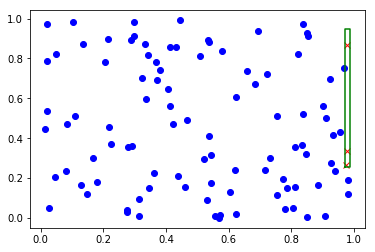

In [172]:
# https://stackoverflow.com/questions/33051244/numpy-filter-points-within-bounding-box

import random
import numpy as np
from matplotlib import pyplot

points = [(random.random(), random.random()) for i in range(100)]

bx1, bx2 = sorted([random.random(), random.random()])
by1, by2 = sorted([random.random(), random.random()])

pts = np.array(points)
ll = np.array([bx1, by1])  # lower-left
ur = np.array([bx2, by2])  # upper-right

inidx = np.all(np.logical_and(ll <= pts, pts <= ur), axis=1)
inbox = pts[inidx]
outbox = pts[np.logical_not(inidx)]

# this is just for drawing
rect = np.array([[bx1, by1], [bx1, by2], [bx2, by2], [bx2, by1], [bx1, by1]])

pyplot.plot(inbox[:, 0], inbox[:, 1], 'rx',
            outbox[:, 0], outbox[:, 1], 'bo',
            rect[:, 0], rect[:, 1], 'g-')
pyplot.show()


In [178]:
pts

array([[7.31639730e-01, 3.03284894e-01],
       [4.59785483e-02, 2.04156185e-01],
       [1.35290992e-01, 8.72746577e-01],
       [1.87337482e-02, 7.88331453e-01],
       [2.12225680e-02, 9.74894339e-01],
       [5.44921120e-01, 1.77149629e-01],
       [6.24952512e-01, 2.21844760e-02],
       [3.12710053e-01, 9.51165835e-02],
       [9.77429193e-01, 8.68589838e-01],
       [1.47664988e-02, 4.48277574e-01],
       [1.28256894e-01, 1.64422611e-01],
       [2.05181492e-01, 7.80377657e-01],
       [2.23104656e-01, 3.69695460e-01],
       [3.21821487e-01, 7.02441327e-01],
       [4.07431503e-01, 6.47589008e-01],
       [6.24915799e-01, 6.07969973e-01],
       [9.78303325e-01, 3.35452328e-01],
       [2.74255881e-01, 3.17493161e-02],
       [3.35437190e-01, 5.97307350e-01],
       [5.43170705e-01, 3.18075215e-01],
       [9.67842359e-01, 7.51188118e-01],
       [9.73364346e-01, 2.67478991e-01],
       [9.07348921e-01, 1.13315851e-02],
       [8.34315200e-01, 3.63959511e-01],
       [9.122915

In [145]:
np.add.reduce([inidx[:10].astype(int), inidx[4174736:4174746].astype(int)])

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [119]:
inidx.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [162]:
img_ids_arr = np.array(img_ids)

(4194304, 2)

In [7]:
 img_ids = [(img_i0, img_i1) for img_i0, img_i1 in np.ndindex(2048, 2048)]

In [22]:
mdf = pickle.load(open('mdf.p', 'rb'))
file_names = set(mdf.file_name)

In [24]:
file_names10 = list(file_names)[:10]

In [111]:
labels = {}
len_data = len(file_names10)
count = 0
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
for fn in file_names10:
    # check if points are in list of bounding boxes
    count += 1 
    img_labels = []
    mdf_fn = mdf[mdf['file_name'] == fn]['adjusted_bbox']
    for x, y, w, h in mdf_fn:
        xmin = int(math.floor(x))
        xmax = int(math.ceil(x + w))
        ymin = int(math.floor(y))
        ymax = int(math.ceil(y + h))
        
        #ll = np.array([xmin, ymin])  # lower-left
        #ur = np.array([xmax, ymax])  # upper-right
        ((p>=x[0]) & (p<=x[1])).all(1)
        inidx = np.all(np.logical_and(ll <= img_ids, img_ids <= ur), axis=1)
        img_labels.append(inidx.astype(int))
    
    sumclip_labels = np.clip(np.add.reduce(img_labels), 0, 1)
    labels[fn] = sumclip_labels
    print(f'Done with image {fn}, {count}/{len_data}')
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2021-12-22 10:44:46
Done with image 0001738.jpg, 1/10
2021-12-22 10:46:31
Done with image 1002256.jpg, 2/10
2021-12-22 10:47:13
Done with image 1000225.jpg, 3/10
2021-12-22 10:51:20
Done with image 0000906.jpg, 4/10
2021-12-22 10:55:44
Done with image 1001750.jpg, 5/10
2021-12-22 11:07:31
Done with image 0000225.jpg, 6/10
2021-12-22 11:11:35
Done with image 1000475.jpg, 7/10
2021-12-22 11:14:00
Done with image 0000902.jpg, 8/10
2021-12-22 11:15:45
Done with image 1002510.jpg, 9/10
2021-12-22 11:20:23
Done with image 0000184.jpg, 10/10
2021-12-22 11:28:51
2021-12-22 11:28:51


In [152]:
mdf[mdf['file_name'] == "0000184.jpg"]

,file_name,adjusted_bbox,attributes,is_chinese,polygon,text
196,0000184.jpg,"[221.99061170674486, 409.5868482124575, 59.827...","[bgcomplex, distorted, occluded, raised]",True,"[[221.99061170674486, 397.8607058295367], [281...",富
197,0000184.jpg,"[281.8178687624633, 443.53094458407037, 53.529...","[bgcomplex, distorted, occluded, raised]",True,"[[281.8178687624633, 433.0391329782991], [335....",润
198,0000184.jpg,"[335.3475198123167, 473.6177572770909, 46.4448...","[bgcomplex, distorted, occluded, raised]",True,"[[335.3475198123167, 464.5145677956129], [381....",酒
199,0000184.jpg,"[381.79236410557183, 499.53870359723163, 39.36...","[bgcomplex, distorted, occluded, raised]",True,"[[381.79236410557183, 491.82413624004687], [42...",店
200,0000184.jpg,"[161.37615390029325, 800.8018303708047, 42.508...","[distorted, raised]",True,"[[161.37615390029325, 798.0466277432388], [203...",计
...,...,...,...,...,...,...
264,0000184.jpg,"[1498.0534824177062, 947.1666748780684, 5.1850...","[distorted, raised]",True,"[[1498.0534824177062, 947.2386897556003], [150...",产
265,0000184.jpg,"[1978.9688345754528, 911.0477992973381, 15.123...",[distorted],True,"[[1978.9688345754528, 910.873970282606], [1994...",鑫
266,0000184.jpg,"[1999.2770300394366, 911.7530484428225, 15.555...",[distorted],True,"[[1999.2770300394366, 911.5742528848124], [201...",鑫
267,0000184.jpg,"[2018.288957707847, 912.4135986988043, 15.9873...",[distorted],True,"[[2018.288957707847, 912.2298365975162], [2034...",辉


In [94]:
rand1 = np.random.randint(0, 2, (2000,2000))
rand2 = np.random.randint(0, 2, (2000,2000))
rand4 = np.random.randint(0, 2, (2000,2000))
rand5 = np.random.randint(0, 2, (2000,2000))
randy = [rand1, rand2, rand4, rand5, rand5, rand5, rand5, rand1, rand2, rand4, rand5, rand5, rand5, rand5, rand1, rand2, rand4, rand5, rand5, rand5, rand5, rand1, rand2, rand4, rand5, rand5, rand5, rand5, rand1, rand2, rand4, rand5, rand5, rand5, rand5, rand1, rand2, rand4, rand5, rand5, rand5, rand5, rand1, rand2, rand4, rand5, rand5, rand5, rand5, ]

In [95]:
rand3 = np.clip(np.add(randy), 0, 1)

ValueError: invalid number of arguments

In [96]:
tic = time.perf_counter()

rand3 = np.clip(np.sum(randy, axis=0), 0, 1)

toc = time.perf_counter()

print(f"Finished in {toc - tic:0.4f} seconds")

Finished in 0.8899 seconds


In [97]:
tic = time.perf_counter()

rand3 = np.clip(np.add.reduce(randy), 0, 1)
toc = time.perf_counter()

print(f"Finished in {toc - tic:0.4f} seconds")

Finished in 0.8359 seconds
